In [19]:
import argparse
from state import State
from data_loader import load_data
from agent import Agent
from attention import Attention
import torch.nn as nn
import torch
import numpy as np
from tqdm import tqdm
from evaluate import computeF1, evaluate
import math
import random

class ReactiveBaseline():
    def __init__(self, l):
        self.l = l
        self.b = 0.0
    def get_baseline_value(self):
        return self.b
    def update(self, target):
        self.b = (1-self.l)*self.b + self.l*target


GAMMA = 1
WORD_EMB_DIM = 4
NODE_EMB_DIM = 16
H_DIM = 16
T = 3
NUM_EPOCH = 20
SOFT_REWARD_SCALE = 0.01
NUM_ROLL_OUT = 1
SHUFFLE = True

# device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# load dataset
rel_embedding, kg, train, test = load_data("countries", WORD_EMB_DIM)

# projection from word embedding to node node embedding
word2node = nn.Linear(WORD_EMB_DIM, NODE_EMB_DIM, bias=False).to(device)

# mutihead self-attention
attention = Attention(2, NODE_EMB_DIM, H_DIM, math.sqrt(H_DIM)).to(device)

# list contains all params that need to optimize
model_param_list = list(word2node.parameters()) + list(attention.parameters())

# init agent
state = State((train[0][1],train[0][2]), kg, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device) # init here to calculate the input size
input_dim = state.get_input_size()
num_rel = len(kg.rel_vocab)
num_entity = len(kg.en_vocab)
baseline = ReactiveBaseline(l=0.02)
agent = Agent(input_dim, 10, 0, 2, num_entity, num_rel, GAMMA, 0.0004, model_param_list, baseline, device)

# training loop
index_list = list(range(len(train)))
for epoch in range(NUM_EPOCH):
    losses = []
    rewards = []
    correct = 0
    f1 = []
    if SHUFFLE:
        random.shuffle(index_list)
    for n in tqdm(range(len(train))):
        # create state from the question
        i = index_list[n]
        for _ in range(NUM_ROLL_OUT):
            state = State((train[i][1],train[i][2]), kg, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device)
            answer = kg.en_vocab[train[i][0]]
            e0 = state.subgraphs[0][0]
            agent.policy.init_path(e0)

            # go for T step
            for step in range(T):
                embedded_state = state.get_embedded_state()
                possible_actions = state.generate_all_possible_actions()
                action = agent.get_action(embedded_state, possible_actions)
                r, e = action
                if step < T-1:
                    agent.hard_reward(0)
                else:
                    nodes = state.get_last_nodes()
                    max_shortest_path = kg.max_shortest_path(nodes)
                    if answer == e:
                        agent.hard_reward(1)
                    else:
                        answer_embedding = state.node_embedding[answer]
                        e_embedding = state.node_embedding[e]
                        #agent.soft_reward(answer_embedding, e_embedding, SOFT_REWARD_SCALE)
                        agent.hard_reward(-max_shortest_path/32)
                state.update(action)
                #print("step: " + str(step) + ", take action: " + str(action) + "result_subgraphs:" + str(state.subgraphs))

            # compute f1
            f1.append(computeF1(answer, e)[-1])
            # update the policy net and record loss
            loss, reward, last_reward = agent.update_policy()
            if last_reward == 1:
                correct += 1
            losses.append(loss)
            rewards.append(reward)

    acc = correct/(NUM_ROLL_OUT*len(train))
    avg_loss = np.mean(losses)
    avg_reward = np.mean(rewards)
    avg_f1 = np.mean(f1)
    print("epoch: {}, loss: {}, reward: {}, acc: {}, f1: {}".format(epoch, avg_loss, avg_reward, acc, avg_f1))

    # evaluate on test set
    if epoch%5 == 0:
        evaluate(test, agent, kg, T, WORD_EMB_DIM, word2node, attention, rel_embedding, device, 15)

  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 0, loss: -0.18041222713401783, reward: -0.11779891304347827, acc: 0.0, f1: 0.06956521739130435


  1%|▏         | 3/230 [00:00<00:07, 29.49it/s]

hit@1: 0.08333333333333333, hit@2: 0.14814814814814814, hit@3: 0.2222222222222222, hit@5: 0.26851851851851855, hit@10: 0.4166666666666667


  2%|▏         | 4/230 [00:00<00:06, 33.60it/s]

epoch: 1, loss: -0.17160843383196903, reward: -0.028532608695652172, acc: 0.0, f1: 0.09565217391304348


  1%|▏         | 3/230 [00:00<00:08, 27.61it/s]

epoch: 2, loss: -0.12617526719063196, reward: 0.3061141304347826, acc: 0.0, f1: 0.1956521739130435


  1%|▏         | 3/230 [00:00<00:09, 23.33it/s]

epoch: 3, loss: -0.19980917115058022, reward: 0.38845108695652175, acc: 0.0, f1: 0.2217391304347826


  1%|▏         | 3/230 [00:00<00:10, 21.67it/s]

epoch: 4, loss: -0.11479779135278596, reward: 0.508695652173913, acc: 0.0, f1: 0.2565217391304348


  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 5, loss: -0.07065448936313255, reward: 0.5832880434782609, acc: 0.0, f1: 0.2782608695652174


  1%|▏         | 3/230 [00:00<00:10, 22.41it/s]

hit@1: 0.17592592592592593, hit@2: 0.28703703703703703, hit@3: 0.3333333333333333, hit@5: 0.3888888888888889, hit@10: 0.5370370370370371


  1%|▏         | 3/230 [00:00<00:10, 20.90it/s]

epoch: 6, loss: -0.11795617837386561, reward: 0.6383152173913044, acc: 0.0, f1: 0.2956521739130435


  1%|▏         | 3/230 [00:00<00:10, 22.14it/s]

epoch: 7, loss: -0.08096509105976692, reward: 0.6529891304347826, acc: 0.0, f1: 0.3


  1%|▏         | 3/230 [00:00<00:09, 23.86it/s]

epoch: 8, loss: -0.05874637724682407, reward: 0.7728260869565218, acc: 0.0, f1: 0.3347826086956522


  1%|▏         | 3/230 [00:00<00:09, 23.25it/s]

epoch: 9, loss: -0.061256104109906506, reward: 0.7528532608695652, acc: 0.0, f1: 0.33043478260869563


  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 10, loss: -0.06449046240160511, reward: 0.7548913043478261, acc: 0.0, f1: 0.33043478260869563


  1%|▏         | 3/230 [00:00<00:10, 20.86it/s]

hit@1: 0.18518518518518517, hit@2: 0.2962962962962963, hit@3: 0.3148148148148148, hit@5: 0.4166666666666667, hit@10: 0.5185185185185185


  1%|▏         | 3/230 [00:00<00:09, 23.54it/s]

epoch: 11, loss: -0.07231957183899837, reward: 0.8457880434782609, acc: 0.0, f1: 0.3565217391304348


  1%|▏         | 3/230 [00:00<00:10, 21.80it/s]

epoch: 12, loss: -0.06157860160064573, reward: 0.7960597826086957, acc: 0.0, f1: 0.3391304347826087


  1%|▏         | 3/230 [00:00<00:09, 23.49it/s]

epoch: 13, loss: -0.04114919180583641, reward: 0.9065217391304348, acc: 0.0, f1: 0.3739130434782609


  1%|▏         | 3/230 [00:00<00:11, 20.54it/s]

epoch: 14, loss: -0.053174148349668826, reward: 0.8201086956521739, acc: 0.0, f1: 0.34782608695652173


  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 15, loss: -0.0357402539982765, reward: 0.8792119565217391, acc: 0.0, f1: 0.3652173913043478


  1%|▏         | 3/230 [00:00<00:10, 22.06it/s]

hit@1: 0.2037037037037037, hit@2: 0.3055555555555556, hit@3: 0.3425925925925926, hit@5: 0.42592592592592593, hit@10: 0.5648148148148148


  1%|▏         | 3/230 [00:00<00:10, 21.23it/s]

epoch: 16, loss: -0.014726911292018547, reward: 0.9052989130434783, acc: 0.0, f1: 0.3739130434782609


  1%|▏         | 3/230 [00:00<00:10, 22.64it/s]

epoch: 17, loss: -0.0384835127734182, reward: 0.9358695652173913, acc: 0.0, f1: 0.3826086956521739


  1%|▏         | 3/230 [00:00<00:10, 21.68it/s]

epoch: 18, loss: -0.03889697234445334, reward: 0.9252717391304348, acc: 0.0, f1: 0.3782608695652174


  1%|▏         | 3/230 [00:00<00:10, 21.70it/s]

epoch: 19, loss: -0.020912317675200267, reward: 0.9220108695652174, acc: 0.0, f1: 0.3782608695652174


  0%|          | 0/108 [00:00<?, ?it/s]

epoch: 20, loss: -0.013679362028869607, reward: 0.9652173913043478, acc: 0.0, f1: 0.391304347826087


  1%|          | 2/230 [00:00<00:11, 19.03it/s]

hit@1: 0.18518518518518517, hit@2: 0.2777777777777778, hit@3: 0.3333333333333333, hit@5: 0.42592592592592593, hit@10: 0.5277777777777778


  1%|▏         | 3/230 [00:00<00:10, 22.37it/s]

epoch: 21, loss: -0.025520658621011726, reward: 1.008016304347826, acc: 0.0, f1: 0.4043478260869565


 18%|█▊        | 42/230 [00:01<00:08, 21.53it/s]


KeyboardInterrupt: 

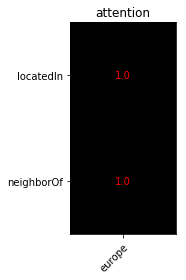

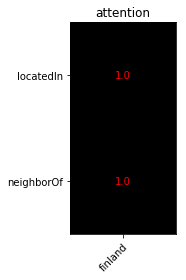

[['europe'], ['finland']]
locatedIn romania


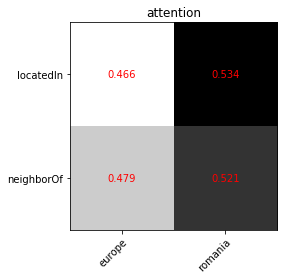

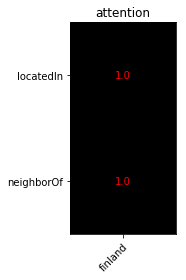

[['europe', 'romania'], ['finland']]
locatedIn guernsey


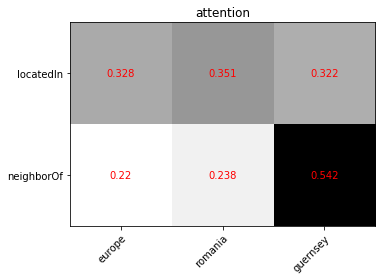

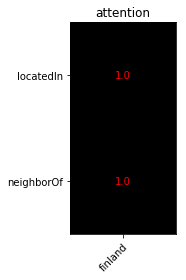

[['europe', 'romania', 'guernsey'], ['finland']]
neighborOf sweden


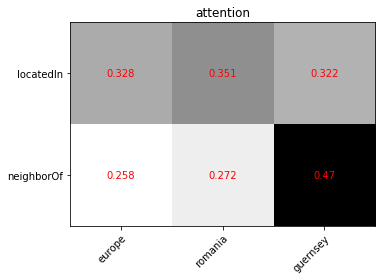

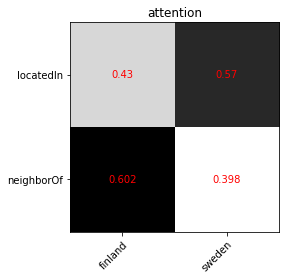

answer: sweden, predicted: sweden


In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# select the question you want to visualize
question_number = 0

def find_ename(e):
    for e_name in state.graph.en_vocab:
        if state.graph.en_vocab[e_name] == e:
            return e_name
        
def find_rname(r):
    for r_name in state.graph.rel_vocab:
        if state.graph.rel_vocab[r_name] == r:
            return r_name
            

def print_attention():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_Rt = F.softmax(L, dim=1)
            
            fig, ax = plt.subplots()
            im = ax.imshow(A_Rt,cmap='gray')
            ax.set_xticks(np.arange(len(rs)))
            ax.set_yticks(np.arange(len(es)))
            ax.set_xticklabels(rs)
            ax.set_yticklabels(es)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(es)):
                for j in range(len(rs)):
                    text = ax.text(j, i, round(A_Rt[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

def print_Agti():
    with torch.no_grad():
        projected_Rt = torch.t(state.word2node(torch.Tensor(state.Rt)))
        rs = []
        for r in state.rs:
            rs.append(find_rname(r))      
                        
        for i, subgraph in enumerate(state.subgraphs):
            gti = []
            es = []
            for e in subgraph:
                gti.append(state.node_embedding[e])
                es.append(find_ename(e))
            gti = torch.Tensor(gti)
            L = torch.mm(gti,projected_Rt)
            A_gti = F.softmax(torch.t(L), dim=1)
            graph = 1 - A_gti
            
            fig, ax = plt.subplots()
            im = ax.imshow(graph,cmap='gray')
            ax.set_xticks(np.arange(len(es)))
            ax.set_yticks(np.arange(len(rs)))
            ax.set_xticklabels(es)
            ax.set_yticklabels(rs)
            
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

            # Loop over data dimensions and create text annotations.
            for i in range(len(rs)):
                for j in range(len(es)):
                    text = ax.text(j, i, round(A_gti[i, j].item(),3), ha="center", va="center", color="r")

            ax.set_title("attention")
            fig.tight_layout()
            plt.show()

state = State((train[question_number][1],train[question_number][2]), kg, WORD_EMB_DIM, word2node, attention, rel_embedding, T, device)
answer = kg.en_vocab[train[question_number][0]]
e0 = state.subgraphs[question_number][0]
agent.policy.init_path(e0)

# go for T step
predicted = None
for step in range(T):
    print_Agti()
    text_subgraphs = []
    for subgraph in state.subgraphs:
        temp = []
        for e in subgraph:
            temp.append(find_ename(e))
        text_subgraphs.append(temp)
    print(text_subgraphs)
    embedded_state = state.get_embedded_state()
    possible_actions = state.generate_all_possible_actions()
    action = agent.get_action(embedded_state, possible_actions)
    r, e = action
    print(find_rname(r), find_ename(e))
    if step < T-1:
        agent.hard_reward(0)
    else:
        predicted = answer
        if answer == e:
            agent.hard_reward(1)
        else:
            answer_embedding = state.node_embedding[answer]
            e_embedding = state.node_embedding[e]
            agent.soft_reward(answer_embedding, e_embedding, SOFT_REWARD_SCALE)
    state.update(action)
print_Agti()
print("answer: " + find_ename(answer) + ", predicted: " + find_ename(predicted))


Parameter containing:
tensor([[-0.0231,  0.0345, -0.0024,  ...,  0.0043,  0.0059, -0.0285],
        [ 0.0075, -0.0653,  0.0121,  ..., -0.0427, -0.0371, -0.0151],
        [ 0.0130, -0.0058, -0.0467,  ..., -0.0144, -0.0086, -0.0456],
        ...,
        [-0.0249,  0.0097,  0.0436,  ..., -0.0175, -0.0471, -0.0223],
        [-0.0365,  0.0299, -0.0302,  ...,  0.0414,  0.0230, -0.0454],
        [-0.0366,  0.0197, -0.0279,  ..., -0.0101, -0.0358, -0.0059]],
       requires_grad=True)
